In [1]:
import book_plots
from book_plots import figsize, set_figsize
import numpy as np
import matplotlib.pyplot as plt
import time
from filterpy.discrete_bayes import normalize
from filterpy.discrete_bayes import update
from filterpy.discrete_bayes import predict

## The Discrete Bayes Algorithm

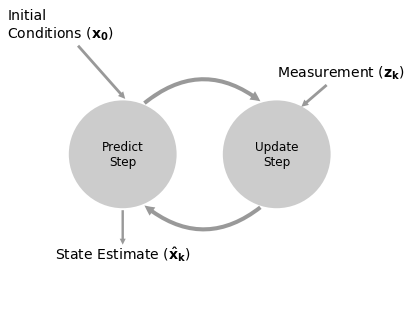

In [2]:
book_plots.predict_update_chart()

This filter is a form of the g-h filter. Here we are using the percentages for the errors to implicitly compute the $g$ and $h$ parameters. We could express the discrete Bayes algorithm as a g-h filter, but that would obscure the logic of this filter.

The filter equations are:

$$\begin{aligned} \bar {\mathbf x} &amp;= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &amp;\text{Predict Step} \\
\mathbf x &amp;= \|\mathcal L \cdot \bar{\mathbf x}\|\, \, &amp;\text{Update Step}\end{aligned}$$
$\mathcal L$ is the usual way to write the likelihood function, so I use that. The $\|\|$ notation denotes taking the norm. We need to normalize the product of the likelihood with the prior to ensure $x$ is a probability distribution that sums to one.

We can express this in pseudocode.

Initialization

1. Initialize our belief in the state

Predict

1. Based on the system behavior, predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction

Update

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. Determine whether the measurement matches each state
4. Update state belief if it matches the measurement

When we cover the Kalman filter we will use this exact same algorithm; only the details of the computation will differ.

In [3]:
def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

In [4]:
def discrete_bayes_sim(pos, kernel, zs, z_prob_correct, sleep=0.25):
    %matplotlib notebook
    N = len(hallway)
    fig = plt.figure()
    for i, z in enumerate(zs):
        plt.cla()
        prior = predict(pos, 1, kernel)
        book_plots.bar_plot(hallway, c='k')
        book_plots.bar_plot(prior, ylim=(0,1.0), c='#ff8015')
        plt.axvline(i % N, lw=5)
        fig.canvas.draw()
        time.sleep(sleep)

        plt.cla()
        likelihood = lh_hallway(hallway, z=z, z_prob=z_prob_correct)
        pos = update(likelihood, prior)
        book_plots.bar_plot(hallway, c='k')
        book_plots.bar_plot(pos, ylim=(0,1.0))
        plt.axvline(i % 10, lw=5)
        fig.canvas.draw()
        time.sleep(sleep)
    plt.show()
    %matplotlib inline
    set_figsize(y=2)
    print('Final posterior:', pos)

In [5]:
# change these numbers to alter the simulation
kernel = (.1, .8, .1)
z_prob = 1.0

# list of perfect measurements
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
measurements = [hallway[i % len(hallway)] for i in range(25)]
pos = np.array([.1]*10)

<IPython.core.display.Javascript object>


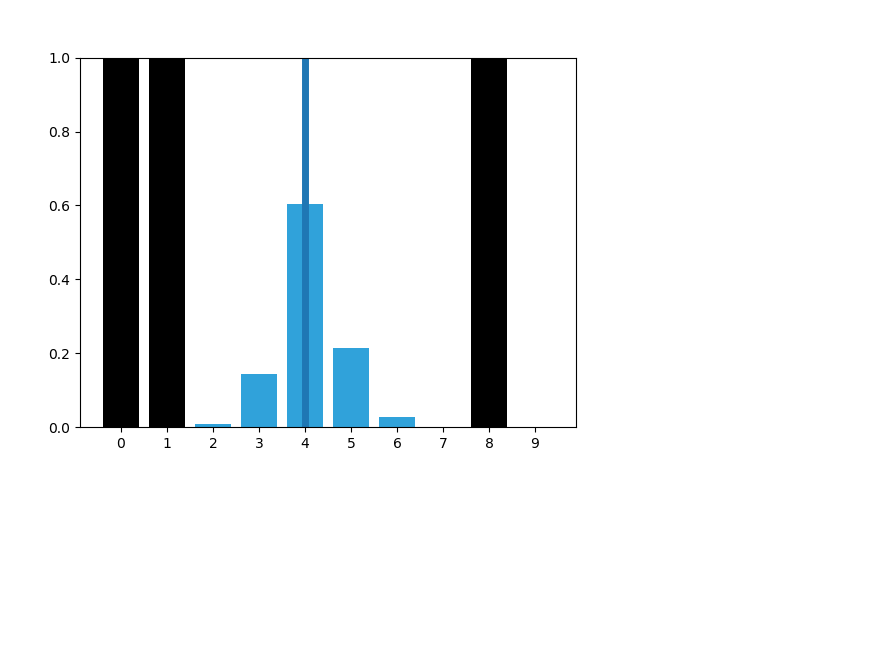

Final posterior: [2.33741164e-19 2.92176686e-20 8.90387872e-03 1.43558180e-01
 6.05193927e-01 2.14806071e-01 2.64418217e-02 1.09612151e-03
 6.74536318e-20 3.09039865e-12]


In [6]:
discrete_bayes_sim(pos, kernel, measurements, z_prob);

#### The Effect of Bad Sensor Data

<IPython.core.display.Javascript object>


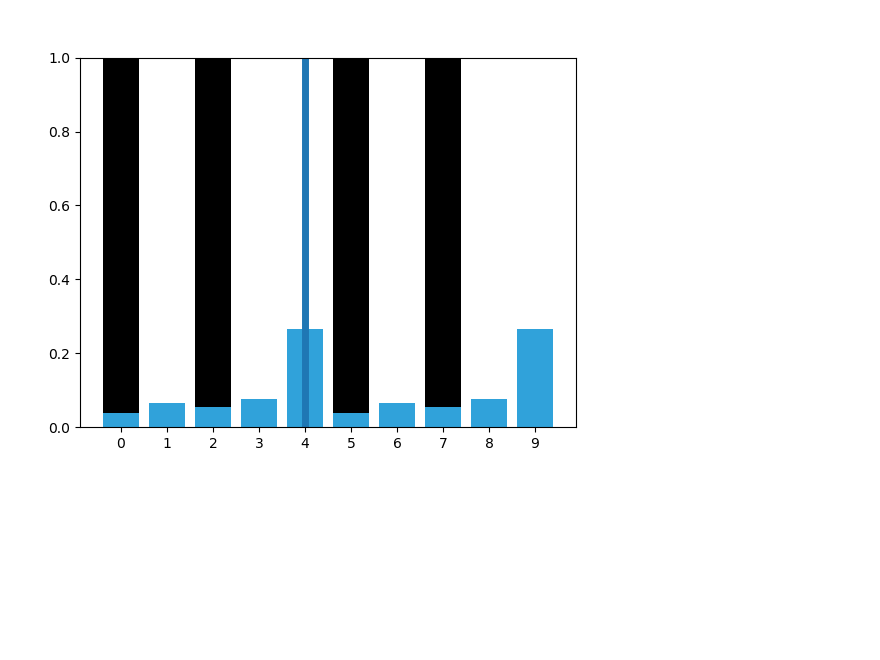

Final posterior: [0.03717865 0.06484698 0.05495885 0.07649026 0.26652526 0.03717865
 0.06484698 0.05495885 0.07649026 0.26652526]


In [7]:
hallway = np.array([1, 0, 1, 0, 0]*2)
kernel = (.1, .8, .1)
prior = np.array([.1] * 10)
measurements = [1, 0, 1, 0, 0]
z_prob = 0.75
discrete_bayes_sim(prior, kernel, measurements, z_prob);

<IPython.core.display.Javascript object>


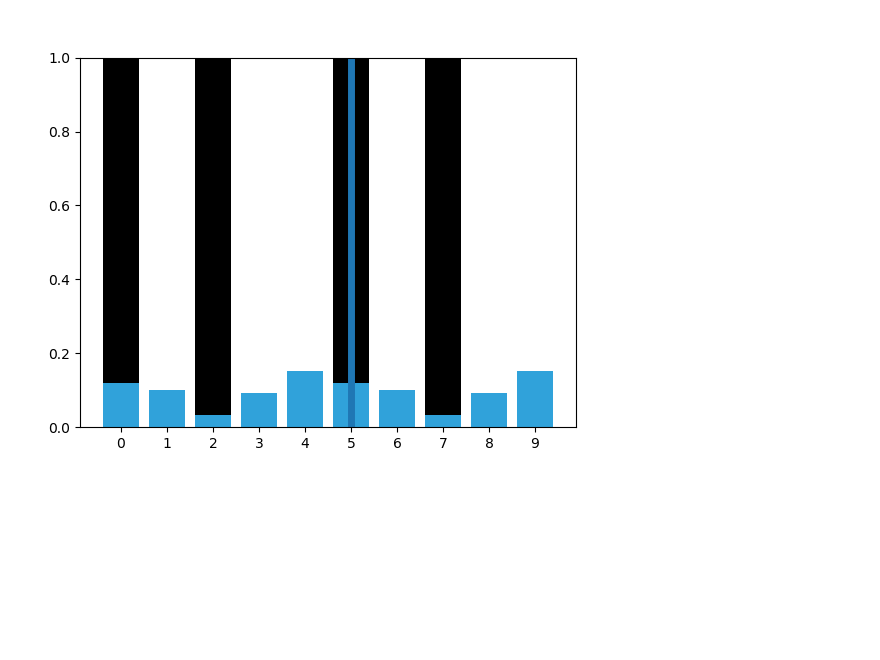

Final posterior: [0.12092218 0.10156778 0.03289279 0.0938479  0.15076936 0.12092218
 0.10156778 0.03289279 0.0938479  0.15076936]


In [8]:
measurements = [1, 0, 1, 0, 0, 0]
discrete_bayes_sim(prior, kernel, measurements, z_prob);

That one bad measurement has significantly eroded our knowledge. Now let's continue with a series of correct measurements.

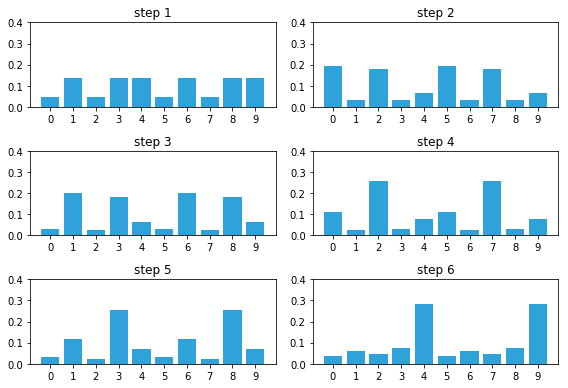

In [9]:
with figsize(y=5.5):
    measurements = [0, 1, 0, 1, 0, 0]
    for i, m in enumerate(measurements):
        likelihood = lh_hallway(hallway, z=m, z_prob=.75)
        posterior = update(likelihood, prior)
        prior = predict(posterior, 1, kernel)
        plt.subplot(3, 2, i+1)
        book_plots.bar_plot(posterior, ylim=(0, .4), title='step {}'.format(i+1))
    plt.tight_layout()

We quickly filtered out the bad sensor reading and converged on the most likely positions for our dog.

### Drawbacks and Limitations

1. **Scaling**     
    Each update() and predict() step requires updating all values in the grid, so a simple four variable problem would require $O(n^4)$ running time per time step. Realistic filters can have 10 or more variables to track, leading to exorbitant computation requirements.
2. The filter is **discrete**, but we live in a continuous world.
3. The filter is multimodal.
4. It requires a measurement of the change in state. We need a motion sensor to detect how much the dog moves.